<a href="https://colab.research.google.com/github/shaye440/colab_demo/blob/master/modelForCompetition_imp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://awscdn.datafountain.cn/cometition_data2/Files/PengCheng2020/RSImage/baseline.zip

--2020-09-20 01:15:34--  https://awscdn.datafountain.cn/cometition_data2/Files/PengCheng2020/RSImage/baseline.zip
Resolving awscdn.datafountain.cn (awscdn.datafountain.cn)... 118.193.97.222, 118.193.97.206, 118.193.97.223, ...
Connecting to awscdn.datafountain.cn (awscdn.datafountain.cn)|118.193.97.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18872584 (18M) [application/zip]
Saving to: ‘baseline.zip’

baseline.zip        100%[===================>]  18.00M  1.17MB/s    in 17s     

2020-09-20 01:15:54 (1.03 MB/s) - ‘baseline.zip’ saved [18872584/18872584]



In [ ]:
!unzip 'baseline.zip'

Archive:  baseline.zip
   creating: baseline/
  inflating: baseline/dataloader.py  
  inflating: baseline/model.py       
  inflating: baseline/predict.py     
  inflating: baseline/README.md      
   creating: baseline/test/
   creating: baseline/test/images/
  inflating: baseline/test/images/1_1_0.tif  
  inflating: baseline/test/images/1_1_1.tif  
  inflating: baseline/test/images/1_1_2.tif  
  inflating: baseline/test/images/1_1_3.tif  
  inflating: baseline/test/images/1_2_0.tif  
  inflating: baseline/test/images/1_2_1.tif  
  inflating: baseline/test/images/1_2_2.tif  
  inflating: baseline/test/images/1_2_3.tif  
  inflating: baseline/test/images/1_3_0.tif  
  inflating: baseline/test/images/1_3_1.tif  
   creating: baseline/test/labels/
  inflating: baseline/test/labels/1_1_0.png  
  inflating: baseline/test/labels/1_1_1.png  
  inflating: baseline/test/labels/1_1_2.png  
  inflating: baseline/test/labels/1_1_3.png  
  inflating: baseline/test/labels/1_2_0.png  
  inflating: b

In [76]:
from matplotlib import pyplot as plt
import skimage.io as io
from torch.utils.data import Dataset
from PIL import Image
import numpy

#root = '/content/baseline/train'

class RSDataset(Dataset):
  def __init__(self, root, transforms, ch):
    super(RSDataset,self).__init__()
    self.root = root
    self.transforms = transforms
    self.listFiles = []
    #my_files = os.listdir("/content/baseline/train")
    #print(my_files)
    if ch == 0:
      imgs_root = os.listdir("/content/baseline/train/images")
      labels_root = os.listdir("/content/baseline/train/labels")
    else:
      imgs_root = os.listdir("/content/baseline/test/images")
      labels_root = os.listdir("/content/baseline/test/labels")
    for files in imgs_root:
      if "tif" in files:
          self.listFiles.append([self.root + '/images/' + files, self.root + '/labels/' + files[:-4]+'.png'])
    #print(self.listFiles)
  def __getitem__(self,index):
    x = Image.open(self.listFiles[index][0])
    x = numpy.array(x)
    x = self.transforms(x)
    y = Image.open(self.listFiles[index][1])
    y = numpy.array(y)
    y = self.transforms(y)
    return x, y
    
  def __len__(self):
    return len(self.listFiles)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fca929609b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


(<matplotlib.axes._subplots.AxesSubplot at 0x7fca92751668>,
 (-0.5, 255.5, 255.5, -0.5))

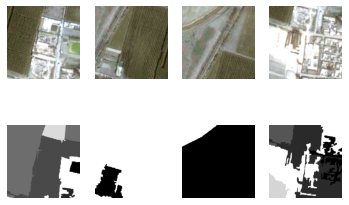

In [77]:
import os
import torch
from  torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

transform = transforms.Compose([
            transforms.ToTensor()
        ])

dataset = RSDataset('/content/baseline/train',transforms=transform, ch=0)
dataset_test = RSDataset('/content/baseline/test',transforms=transform,ch=1)

#dataset = ImageFolder('/content/data/dogcat_2',transform=transform)

dataloader = DataLoader(dataset,batch_size=4,shuffle=True,num_workers=1,drop_last=False)
dataloader_test = DataLoader(dataset_test,batch_size=4,shuffle=True,num_workers=1,drop_last=False)

dataiter = iter(dataloader)
imgs = next(dataiter)
imgs0 = imgs[0]
imgs1 = imgs[1]
imgs0 = imgs0.permute(0, 2, 3, 1)
imgs1 = imgs1.permute(0, 2, 3, 1)



plt.subplot(241),plt.imshow(imgs0[0]),plt.axis('off')
plt.subplot(242),plt.imshow(imgs0[1]),plt.axis('off')
plt.subplot(243),plt.imshow(imgs0[2]),plt.axis('off')
plt.subplot(244),plt.imshow(imgs0[3]),plt.axis('off')

plt.subplot(245),plt.imshow(imgs1[0][:,:,0],cmap='gray'),plt.axis('off')
plt.subplot(246),plt.imshow(imgs1[1][:,:,0],cmap='gray'),plt.axis('off')
plt.subplot(247),plt.imshow(imgs1[2][:,:,0],cmap='gray'),plt.axis('off')
plt.subplot(248),plt.imshow(imgs1[3][:,:,0],cmap='gray'),plt.axis('off')




In [78]:
import torch
import torch.nn as nn
import torch.functional as F

class UNet(nn.Module):
    def __init__(self, input_nc, output_nc):
        super(UNet, self).__init__()
        self.in_conv1 = nn.Conv2d(input_nc, 64, kernel_size=3, stride=1, padding=1)
        self.in_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.pooling1 = nn.MaxPool2d(2)
        self.conv1_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.pooling2 = nn.MaxPool2d(2)
        self.conv2_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.pooling3 = nn.MaxPool2d(2)
        self.conv3_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.pooling4 = nn.MaxPool2d(2)
        self.conv4_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.upsampling1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv5_1 = nn.Conv2d(1024, 256, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.upsampling2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv6_1 = nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1)
        self.conv6_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.upsampling3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv7_1 = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1)
        self.conv7_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.upsampling4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv8_1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv8_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.out_conv = nn.Conv2d(64, output_nc, kernel_size=1, stride=1, padding=0)

        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        self.bn512 = nn.BatchNorm2d(512)

        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        c1 = self.relu(self.bn64(self.in_conv1(input)))
        c2 = self.relu(self.bn64(self.in_conv2(c1)))

        e1_ = self.relu(self.bn128(self.conv1_1(self.pooling1(c2))))
        e1 = self.relu(self.bn128(self.conv1_2(e1_)))

        e2_ = self.relu(self.bn256(self.conv2_1(self.pooling1(e1))))
        e2 = self.relu(self.bn256(self.conv2_2(e2_)))

        e3_ = self.relu(self.bn512(self.conv3_1(self.pooling1(e2))))
        e3 = self.relu(self.bn512(self.conv3_2(e3_)))

        e4_ = self.relu(self.bn512(self.conv4_1(self.pooling1(e3))))
        e4 = self.relu(self.bn512(self.conv4_2(e4_)))

        d1_1 = self.upsampling1(e4)
        d1_2 = torch.cat([d1_1, e3], dim=1)
        d1_ = self.relu(self.bn256(self.conv5_1(d1_2)))
        d1 = self.relu(self.bn256(self.conv5_2(d1_)))

        d2_1 = self.upsampling1(d1)
        d2_2 = torch.cat([d2_1, e2], dim=1)
        d2_ = self.relu(self.bn128(self.conv6_1(d2_2)))
        d2 = self.relu(self.bn128(self.conv6_2(d2_)))

        d3_1 = self.upsampling1(d2)
        d3_2 = torch.cat([d3_1, e1], dim=1)
        d3_ = self.relu(self.bn64(self.conv7_1(d3_2)))
        d3 = self.relu(self.bn64(self.conv7_2(d3_)))

        d4_1 = self.upsampling1(d3)
        d4_2 = torch.cat([d4_1, c2], dim=1)
        d4_ = self.relu(self.bn64(self.conv8_1(d4_2)))
        d4 = self.relu(self.bn64(self.conv8_2(d4_)))

        output = self.sigmoid(self.out_conv(d4))

        return output


In [79]:
import torch

net = UNet(3,1)

ce_loss = nn.BCELoss()
#ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.001)

epoch = 5
batch_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)
net.train()
for epoch in range(1,100+1):
  for batch_idx, (data, targets ) in enumerate(dataloader):
          data = data.to(device)
          targets = targets.to(device)
          optimizer.zero_grad()
          output = net(data)
          output = output.view(-1).float()
          targets = targets.view(-1).float()
          loss = ce_loss(output,targets)
          loss.backward()
          optimizer.step()
          
          print('Train Epoch: {} batch:{}\tLoss: {:.6f}'.format(
              epoch, batch_idx , loss.item()))
          

cuda
Train Epoch: 1 batch:0	Loss: 41.674469
Train Epoch: 1 batch:1	Loss: -11.769756
Train Epoch: 1 batch:2	Loss: -83.829010
Train Epoch: 2 batch:0	Loss: -118.290932
Train Epoch: 2 batch:1	Loss: -207.881775
Train Epoch: 2 batch:2	Loss: -202.313324
Train Epoch: 3 batch:0	Loss: -283.774719
Train Epoch: 3 batch:1	Loss: -289.861877
Train Epoch: 3 batch:2	Loss: -399.277405
Train Epoch: 4 batch:0	Loss: -381.226349
Train Epoch: 4 batch:1	Loss: -413.607727
Train Epoch: 4 batch:2	Loss: -366.060120
Train Epoch: 5 batch:0	Loss: -407.149170
Train Epoch: 5 batch:1	Loss: -443.673035
Train Epoch: 5 batch:2	Loss: -466.448059
Train Epoch: 6 batch:0	Loss: -479.001984
Train Epoch: 6 batch:1	Loss: -455.984314
Train Epoch: 6 batch:2	Loss: -517.218384
Train Epoch: 7 batch:0	Loss: -496.681183
Train Epoch: 7 batch:1	Loss: -499.435211
Train Epoch: 7 batch:2	Loss: -627.066406
Train Epoch: 8 batch:0	Loss: -568.425842
Train Epoch: 8 batch:1	Loss: -588.262085
Train Epoch: 8 batch:2	Loss: -514.726074
Train Epoch: 9 

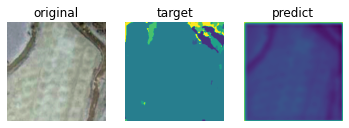

Train Epoch: 1 batch:0	Loss: -2162.999023


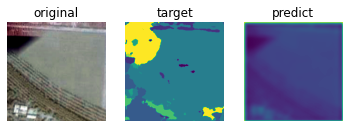

Train Epoch: 1 batch:1	Loss: -2258.539062


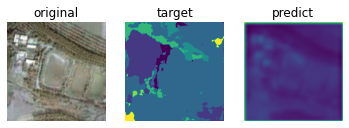

Train Epoch: 1 batch:2	Loss: -2124.313965


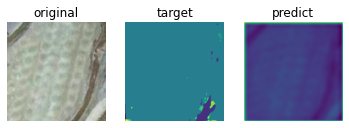

Train Epoch: 2 batch:0	Loss: -2150.005859


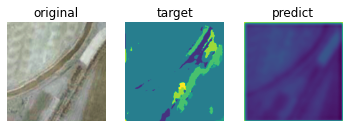

Train Epoch: 2 batch:1	Loss: -2274.404785


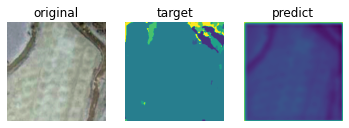

Train Epoch: 2 batch:2	Loss: -2118.569092


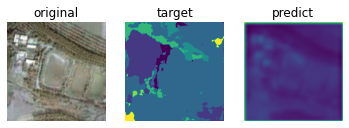

Train Epoch: 3 batch:0	Loss: -2159.100586


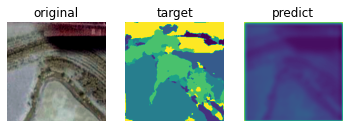

Train Epoch: 3 batch:1	Loss: -2288.705078


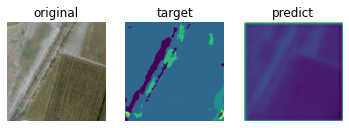

Train Epoch: 3 batch:2	Loss: -2071.779297


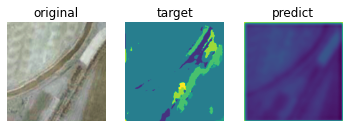

Train Epoch: 4 batch:0	Loss: -2097.755859


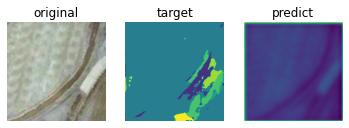

Train Epoch: 4 batch:1	Loss: -2326.910400


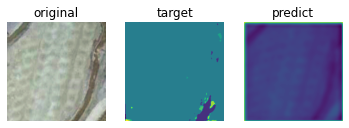

Train Epoch: 4 batch:2	Loss: -2118.058105


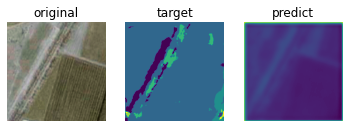

Train Epoch: 5 batch:0	Loss: -2097.791016


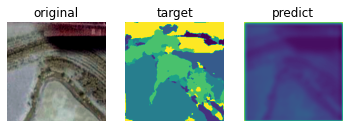

Train Epoch: 5 batch:1	Loss: -2254.575439


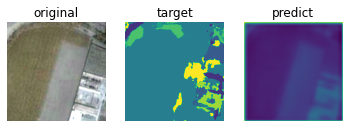

Train Epoch: 5 batch:2	Loss: -2262.656738


In [80]:
net.eval()

for epoch in range(1,5+1):
  for batch_idx, (data, targets ) in enumerate(dataloader_test):
          
          data = data.to(device)
          targets = targets.to(device)
          output = net(data)
          #print(targets.shape)
          #print(targets[0].shape)
          d = data[0].permute(1,2,0).cpu()
          t = targets[0].permute(1,2,0).cpu()
          o = output[0].permute(1,2,0).cpu().detach().numpy()
          
          plt.subplot(131),plt.imshow(d[ :, :,:].squeeze()),plt.title('original'),plt.axis('off')
          plt.subplot(132),plt.imshow(t[ :, :,:].squeeze()),plt.title('target'),plt.axis('off')
          plt.subplot(133),plt.imshow(o[ :, :,:].squeeze()),plt.title('predict'),plt.axis('off')
          plt.show()
          
          output = output.view(-1).float()
          targets = targets.view(-1).float()
          loss = ce_loss(output,targets)
          print('Train Epoch: {} batch:{}\tLoss: {:.6f}'.format(
              epoch, batch_idx , loss.item()))